# Simulation-based Calibration in SBI

After a density estimator has been trained with simulated data to obtain a posterior,
the estimator should be made subject to several **diagnostic tests**. This needs to be
performed before being used for inference given the actual observed data. _Posterior
Predictive Checks_ (see [10_diagnostics_posterior_predictive_checks
tutorial](10_diagnostics_posterior_predictive_checks.md)) provide one way to "critique" a trained
estimator based on its predictive performance. Another important approach to such
diagnostics is simulation-based calibration as developed by [Cook et al,
2006](https://www.tandfonline.com/doi/abs/10.1198/106186006X136976) and [Talts et al,
2018](https://arxiv.org/abs/1804.06788). This tutorial will demonstrate and teach you
this technique with sbi.

**Simulation-based calibration** (SBC) provides a (qualitative) view and a quantitive measure to check, whether the variances of the posterior are balanced, i.e., neither over-confident nor under-confident. As such, SBC can be viewed as a necessary condition (but not sufficient) for a valid inference algorithm: If SBC checks fail, this tells you that your inference is invalid. If SBC checks pass, this is no guarantee that the posterior estimation is working.


## In a nutshell

To run SBC,

1. we sample `theta_o_i` values from the prior of the problem at hand
2. we simulate "observations" from these parameters: `x_o_i = simulator(theta_o_i)`
3. we perform inference given each observation `x_o_i`.

This produces a separate posterior $p_i(\theta | x_{o,i})$ for each of `x_o_i`. The key step for SBC is to generate a set of posterior samples $\{\theta\}_i$ from each posterior. We call this `theta_i_s`, referring to `s` samples from posterior $p_i(\theta | x_{o,i})$). Next, we rank the corresponding `theta_o_i` under this set of samples. A rank is computed by counting how many samples `theta_i_s` fall below their corresponding `theta_o_i` value (see section 4.1 in Talts et al.). These ranks are then used to perform the SBC check itself.

### Key ideas behind SBC

The core idea behind SBC is two fold:

- SBC ranks of ground truth parameters under the inferred posterior samples follow a uniform distribution.  
  (If the SBC ranks are not uniformly distributed, the posterior is not well calibrated.)

- samples from the data averaged posterior (ensemble of randomly chosen posterior samples given multiple distinct observations `x_o`) are distributed according to the prior

### What can SBC diagnose?

**SBC can inform us whether we are not wrong.** However, it cannot tell us whether we are right, i.e., SBC checks a necessary condition. For example, imagine you run SBC using the prior as a posterior. The ranks would be perfectly uniform. But the inference would be wrong as this scenario would only occur if the posterior is uninformative.

**Posterior Predictive Checks can be seen as the complementary sufficient check** for the posterior (only as a methaphor, no theoretical guarantees here). Using the prior as a posterior and then doing predictive checks would clearly show that inference failed.

To summarize, SBC can:

- tell us whether the SBI method applied to the problem at hand produces posteriors that have well-calibrated uncertainties,
- and if the posteriors have uncalibrated uncertainties, SBC surfaces what kind of systematic bias is present: negative or positive bias (shift in the mean of the predictions) or over- or underdispersion (too large or too small variance)


## A healthy posterior

Let's take the gaussian linear simulator from the previous tutorials and run inference with NPE on it.

**Note:** SBC requires running inference several times. Using SBC with amortized methods like NPE is hence a justified endavour: repeated inference is cheap and SBC can be performed with little runtime penalty. This does not hold for sequential methods or anything relying on MCMC or VI. Should you require methods of MCMC or VI, consider exploiting parallelization and set `num_workers>1` in the sbc functions.


In [1]:
import torch
from torch import eye, ones
from torch.distributions import MultivariateNormal

from sbi.analysis.plot import sbc_rank_plot
from sbi.diagnostics import check_sbc, check_tarp, run_sbc, run_tarp
from sbi.inference import NPE

# Set random seed
_ = torch.manual_seed(42)

In [2]:
num_dim = 2
num_simulations = 10_000

prior_mean = ones(num_dim)
prior_cov = 2 * eye(num_dim)
prior = MultivariateNormal(
    loc=prior_mean, covariance_matrix=prior_cov, validate_args=False
)

## An ideal case

To explore SBC, we make our life easy and assume that we deal with a problem where the likelihood is modelled by an identity mapping and a bit of smear. But to start, we only use an almost vanishing smear of `0.01`.


In [3]:
default_likelihood_loc = 0.0  # let's start with 0 shift
default_likelihood_scale = 0.01  # let's smear theta only by a little bit


def simulator(theta, loc=default_likelihood_loc, scale=default_likelihood_scale):
    """linear gaussian inspired by sbibm
    https://github.com/sbi-benchmark/sbibm/blob/15f068a08a938383116ffd92b92de50c580810a3/sbibm/tasks/gaussian_linear/task.py#L74
    """
    num_dim = theta.shape[-1]
    cov_ = scale * eye(num_dim)  # always positively semi-definite

    # using validate_args=False disables sanity checks on `covariance_matrix`
    # for the sake of speed
    value = MultivariateNormal(
        loc=(theta + loc), covariance_matrix=cov_, validate_args=False
    ).sample()
    return value

theta = prior.sample((num_simulations,))
x = simulator(theta)

In [4]:
# let's sample an observation from the parameters we
# just produced
theta_o = prior.sample((1,))
x_o = simulator(theta_o)
print("theta:", theta_o.numpy())
print("x    :", x_o.numpy())

theta: [[3.8389134 1.6634762]]
x    : [[3.9267206 1.6138272]]


In [5]:
# we use a mdn model to have a fast turnaround with training the NPE
inferer = NPE(prior, density_estimator="nsf")
# append simulations and run training.
inferer.append_simulations(theta, x).train(training_batch_size=200);

 Neural network successfully converged after 93 epochs.

In [8]:
posterior = inferer.build_posterior()
posterior_samples = posterior.sample((10_000,), x=x_o)

# Generate predictive samples by simulating from posterior samples.
posterior_predictive_samples = simulator(posterior_samples)

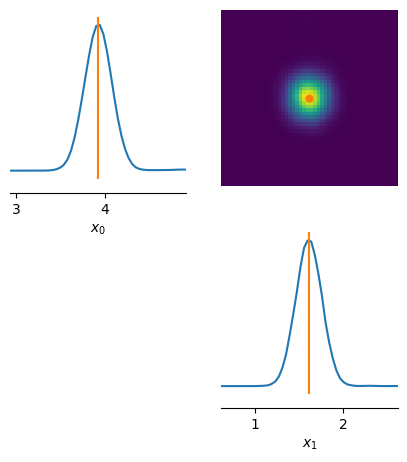

In [9]:
# let's do some posterior predictive checks to see if the
# posterior predictive samples cluster aournd the observation `x_o`.
from sbi.analysis import pairplot

fig, ax = pairplot(
    samples=posterior_predictive_samples,
    points=x_o,
    limits=list(zip(x_o.flatten() - 1.0, x_o.flatten() + 1.0)),
    upper="kde",
    diag="kde",
    figsize=(5, 5),
    labels=[rf"$x_{d}$" for d in range(3)],
)

The observation `x_o` falls into the support of the predicted posterior samples, i.e. it is within `simulator(posterior_samples)`. Given the simulator, this is indicative that our posterior estimates the data well.


### Running SBC

We have a working and trained posterior at this point! Hurray! Let's look at the SBC metrics now.


In [10]:
num_sbc_samples = 200  # choose a number of sbc runs, should be ~100s

# generate ground truth parameters and corresponding simulated observations for SBC.
thetas = prior.sample((num_sbc_samples,))
xs = simulator(thetas)

SBC is implemented in `sbi` for your use on any `sbi` posterior. To run it, we only need to call `run_sbc` with appropriate parameters.

**Note**: For amortized neural posteriors (like in this tutorial), execution of `sbc` is expected to be fast. For posteriors that conduct inference with MCMC and hence are slow, `run_sbc` exposes the use of multiple internal parallel workers to the user. To use this feature, add `num_workers = 2` to the parameters for use of two workers. See the API documentation for details.


In [11]:
# run SBC: for each inference we draw 1000 posterior samples.
num_posterior_samples = 1_000
num_workers = 1
ranks, dap_samples = run_sbc(
    thetas, xs, posterior, num_posterior_samples=num_posterior_samples, num_workers=num_workers
)

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Calculating ranks for 200 sbc samples.:   0%|          | 0/200 [00:00<?, ?it/s]

`sbi` establishes two methods to do simulation-based calibration:

- metrics to compare the sbc ranks with a uniform distribution
- control plots for visual inspections like fig. 1 or 2 in [Talts et al, 2018](https://arxiv.org/abs/1804.06788)

The `ranks` count is performed per dimension of `theta`, i.e. on the 1-D marginal posterior estimates. According to theory, the distribution of these ranks (per dimension of `theta`) should turn out to be uniformly distributed.

The data average posterior `dap` (see equation 1 of [Talts et al, 2018](https://arxiv.org/abs/1804.06788)) is yet another metric of interest. It is built from singular random samples of the estimated posterior samples for each `xs` above. The `dap` is expected to match the prior distribution used (see equation 1 in [Talts et al, 2018](https://arxiv.org/abs/1804.06788) too).


In [12]:
check_stats = check_sbc(
    ranks, thetas, dap_samples, num_posterior_samples=num_posterior_samples
)

The `check_stats` variable created contains a dictionary with 3 metrics that help to judge our posterior. The "first" two compare the ranks to a uniform distribution.


### Ranks versus Uniform distribution


In [13]:
print(
    f"""kolmogorov-smirnov p-values \n
    check_stats['ks_pvals'] = {check_stats['ks_pvals'].numpy()}"""
)

kolmogorov-smirnov p-values 

    check_stats['ks_pvals'] = [0.9826095  0.11227471]


The Kolmogorov-Smirnov (KS test, see also [here](https://en.wikipedia.org/wiki/Kolmogorov%E2%80%93Smirnov_test#Two-sample_Kolmogorov%E2%80%93Smirnov_test)) as used by `check_sbc` provides p-values `pvals` on the null hypothesis that the samples from `ranks` are drawn from a uniform distribution (in other words `H_0: PDF(ranks) == PDF(uniform)`). We are provided two values as our problem is two-dimensional - one p-value for each dimension.

The null hypothesis (of both distributions being equal) is rejected if the p-values fall below a significance threshold (usually `< 0.05`). 
Therefore, the values we see here should ideally be much larger than `0.05` because the ranks should ideally be close to a uniform distribution. If they are below `0.05` then this indicates that the posterior is non well-calibrated. Note, however, that we can obtain arbitrarily small p-values if we use a large number of samples, (`num_sbc_samples`). Note also that this is only a neccessary check, i.e., we can only conclude that the posterior is not miscalibrated, not that it is accurate. 


In [14]:
print(
    f"c2st accuracies \ncheck_stats['c2st_ranks'] = {check_stats['c2st_ranks'].numpy()}"
)

c2st accuracies 
check_stats['c2st_ranks'] = [0.53 0.52]


The second tier of metrics comparing `ranks` with a uniform distributions is a `c2st` test (see [here](http://arxiv.org/abs/1610.06545) for details). This is a nonparametric two sample test based on training a classifier to differentiate two ensembles. Here, these two ensembles are the observed `ranks` and samples from a uniform distribution. The values reported are the accuracies from n-fold cross-validation. If you see values around `0.5`, the classifier was unable to differentiate both ensembles, i.e. `ranks` are very uniform. If the values are high towards `1`, this matches the case where `ranks` is very unlike a uniform distribution.


### Data averaged posterior (DAP) versus prior


In [15]:
print(f"- c2st accuracies check_stats['c2st_dap'] = {check_stats['c2st_dap'].numpy()}")

- c2st accuracies check_stats['c2st_dap'] = [0.4825 0.4475]


The last metric reported is again based on `c2st` computed per dimension of `theta`. If you see values around `0.5`, the `c2st` classifier was unable to differentiate both ensembles for each dimension of `theta`, i.e. `dap` are much like (if not identical to) the prior. If the values are very high towards `1`, this represents the case where `dap` is very unlike the prior distribution.


### Visual Inspection


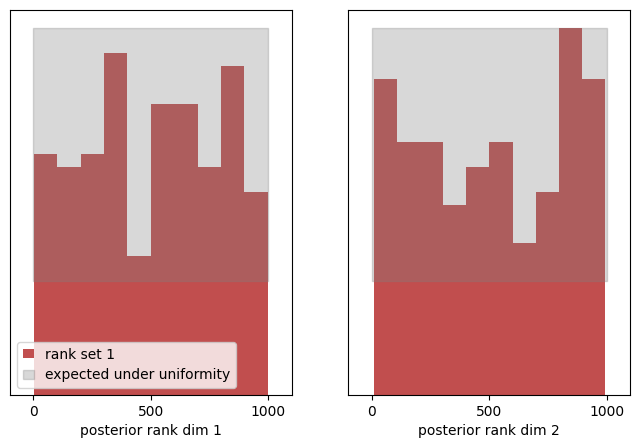

In [16]:
f, ax = sbc_rank_plot(
    ranks=ranks,
    num_posterior_samples=num_posterior_samples,
    plot_type="hist",
    num_bins=None,  # by passing None we use a heuristic for the number of bins.
)

The two plots visualize the distribution of `ranks` (here depicted in red) in each dimension. Highlighted in grey, you see the 99% confidence interval of a uniform distribution given the number of samples provided. In plain english: for a uniform distribution, we would expect 1 out of 100 (red) bars to lie outside the grey area.

We also observe, that the entries fluctuate to some degree. This can be considered a hint that `sbc` should be conducted with a lot more samples than `1000`. A good rule of thumb is that given the number of bins `B` and the number of SBC samples `N` (chosed to be `1_000` here) should amount to `N / B ~ 20`.


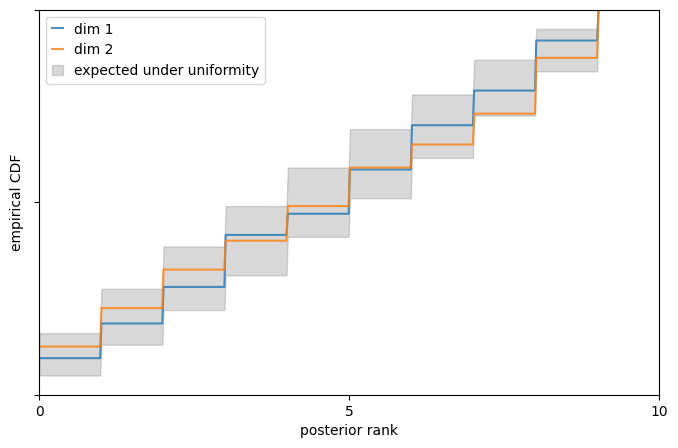

In [17]:
f, ax = sbc_rank_plot(ranks, 1_000, plot_type="cdf")

The above provides a visual representation of the cumulative density function (CDF) of `ranks` (blue and orange for each dimension of `theta`) with respect to the 95% confidence interval of a uniform distribution (grey).


## multi dimensional SBC

So far, we have performed the SBC checks for each dimension of our parameters $\theta$ separately. SBI offers a way to perform this check for all dimensions at once.

In [18]:
# use reduce_fns in order to map the test statistic to only one dimension
ranks, dap_samples = run_sbc(
    thetas,
    xs,
    posterior,
    num_posterior_samples=num_posterior_samples,
    reduce_fns=posterior.log_prob,
)
check_stats = check_sbc(ranks, thetas, dap_samples, 1_000)
print(check_stats)

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Calculating ranks for 200 sbc samples.:   0%|          | 0/200 [00:00<?, ?it/s]

{'ks_pvals': tensor([0.3516]), 'c2st_ranks': tensor([0.4775], dtype=torch.float64), 'c2st_dap': tensor([0.4950, 0.4775], dtype=torch.float64)}


In the code above, we depart from the default behavior of `run_sbc`. The standard behavior of `run_sbc` is to calculate the SBC ranks of parameters $\theta$ by comparing the marginal values of the predicted parameter $\theta_i$ to the reference value $\theta_o$, i.e. we are ranking each parameter only within its marginal dimension `idx` which evaluates `theta_i[idx] < theta_o[idx]` to perform sbc ranking.  

The `reduce_fns` parameter of `run_sbc` allows users to specify a `Callable` which is invoked on the tuple `(theta,x)` before the sbc ranking is performed. As an example, we specify `reduce_fns=posterior.log_prob` here to rank according to the log probability of theta (given x) under the posterior. This results in the ranking being performed across all dimensions of `theta` at once (instead of each marginal dimension separately) by *reducing* `theta` to the log probabilities under the posterior. Internally, `run_sbc` would then evaluate `posterior.log_prob(theta_i, x_o) < posterior.log_prob(theta_o, x_o)` to perform the ranking.

Note: The results of `check_sbc` using ranking `posterior.log_prob` values from above produce the same conclusion as those using the marginals from further above. `ks_pvals` is above `0.05` again and `c2st_ranks` is about `0.5` again.

# When things go haywire

Next, we would like to explore some pathologies visible in sbc plots which can hint at our estimated posterior being somewhat wrong or completely off.


## A shifted posterior mean

In this scenario, we emulate the situation that our posterior estimates incorrectly with a constant shift. We reuse our trained NPE posterior from above and wrap it so that all samples returned expose a constant shift by `+0.1`.


In [17]:
from utils_13_diagnosis_sbc import BiasedPosterior

# this posterior shifts the expected value of the prior by .1
posterior_ = BiasedPosterior(posterior, shift=0.1)

In [18]:
ranks, dap_samples = run_sbc(thetas, xs, posterior_)
check_stats = check_sbc(ranks, thetas, dap_samples, 1_000)
print(check_stats)

{'ks_pvals': tensor([1.7612e-37, 1.3333e-34]), 'c2st_ranks': tensor([0.5900, 0.5725], dtype=torch.float64), 'c2st_dap': tensor([0.4350, 0.4950], dtype=torch.float64)}


We can see that the Kolmogorov-Smirnov p-values vanish (`'ks_pvals': tensor([0., 0.])`). Thus, we can reject the hypothesis that the `ranks` PDF is a uniform PDF. The `c2st` accuracies show values higher than `0.5`. This is supports as well that the `ranks` distribution is not a uniform PDF.


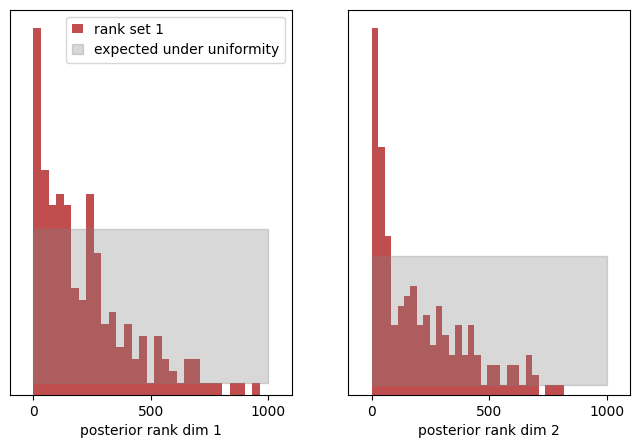

In [19]:
f, ax = sbc_rank_plot(ranks, 1_000, plot_type="hist", num_bins=30)

Inspecting the histograms for both dimenions, the rank distribution is clearly tilted to low rank values for both dimensions. Because we have shifted the expected value of the posterior to higher values (by `0.1`), we see more entries at low rank values.


Let's try to shift all posterior samples in the opposite direction. We shift the expectation value by `-0.1`:


In [20]:
posterior_ = BiasedPosterior(posterior, shift=-0.1)

{'ks_pvals': tensor([1.6989e-28, 1.6361e-21]), 'c2st_ranks': tensor([0.6200, 0.5475], dtype=torch.float64), 'c2st_dap': tensor([0.4525, 0.4475], dtype=torch.float64)}


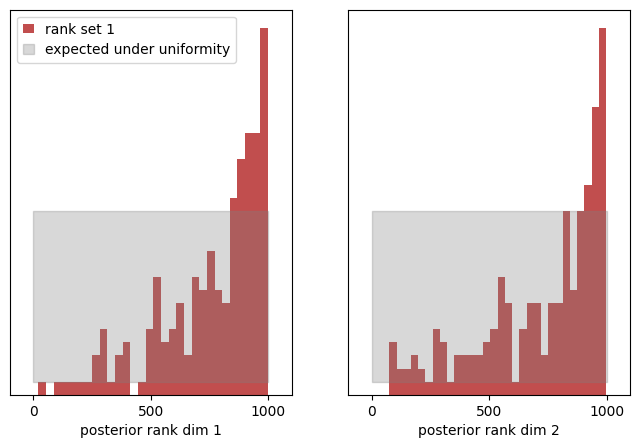

In [21]:
ranks, dap_samples = run_sbc(thetas, xs, posterior_)
check_stats = check_sbc(ranks, thetas, dap_samples, 1_000)
print(check_stats)
f, ax = sbc_rank_plot(ranks, 1_000, plot_type="hist", num_bins=30)

A similar behavior is observed, but this time we see an upshot of ranks to higher values of posterior rank. Because we have shifted the expected value of the posterior to smaller values, we see an upshot in high rank counts.

The historgams above provide convincing evidence that this is not a uniform distribution.

To conlude at this point, **the rank distribution is capable of identifying pathologies of the estimated posterior**:

- a **left-skewed rank distribution** shows a systematic **underestimation of the posterior mean**  
  (we shifted the posterior by `0.1`)
- a **rank-skewed rank distribution** shows a systematic **overestimation of the posterior mean**  
  (we shifted the posterior by `-0.1`)


## A dispersed posterior

In this scenario we emulate the situation if our posterior estimates incorrectly with a dispersion, i.e. the posterior is too wide or too thin. We reuse our trained NPE posterior from above and wrap it so that all samples return a dispersion by 100% more wide (`dispersion=2.0`), i.e. the variance is overestimated by a factor of 2.


In [22]:
from utils_13_diagnosis_sbc import DispersedPosterior

# this posterior which disperses the expected posterior value of the prior by 2.
posterior_ = DispersedPosterior(posterior, dispersion=2.0)

{'ks_pvals': tensor([0.0006, 0.0003]), 'c2st_ranks': tensor([0.4800, 0.4900], dtype=torch.float64), 'c2st_dap': tensor([0.4375, 0.4850], dtype=torch.float64)}


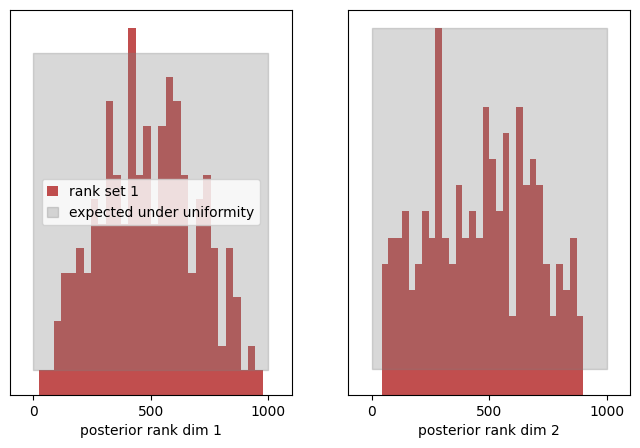

In [23]:
ranks, dap_samples = run_sbc(thetas, xs, posterior_)
check_stats = check_sbc(ranks, thetas, dap_samples, 1_000)
print(check_stats)
f, ax = sbc_rank_plot(ranks, 1_000, plot_type="hist", num_bins=30)

The rank histograms now look more like a very wide gaussian distribution centered in the middle. The KS p-values again vanish unsurprisingly (we must reject the hypothesis that both distributions are from the same uniform PDF) and the c2st_ranks indicate that the rank histogram is not uniform too. As our posterior samples are distributed too broad now, we obtain more "medium" range ranks and hence produce the peak of ranks in the center of the histogram.


We can repeat this exercise by making our posterior too thin, i.e. the variance of the posterior is too small. Let's cut it by half (`dispersion=0.5`).


In [24]:
posterior_ = DispersedPosterior(posterior, dispersion=0.5)

{'ks_pvals': tensor([2.8365e-01, 1.3149e-04]), 'c2st_ranks': tensor([0.4950, 0.5300], dtype=torch.float64), 'c2st_dap': tensor([0.4175, 0.4750], dtype=torch.float64)}


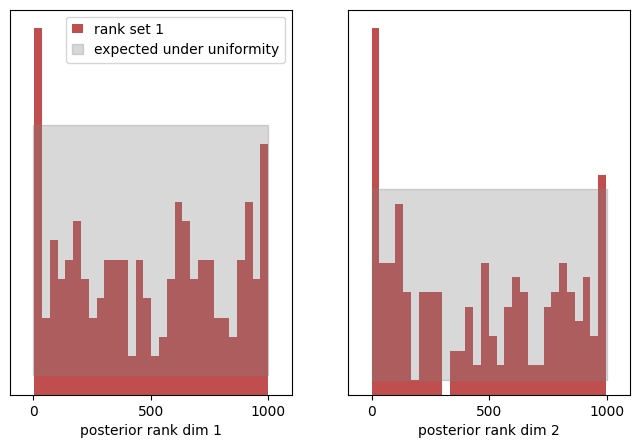

In [25]:
ranks, dap_samples = run_sbc(thetas, xs, posterior_)
check_stats = check_sbc(ranks, thetas, dap_samples, 1_000)
print(check_stats)
f, ax = sbc_rank_plot(ranks, 1_000, plot_type="hist", num_bins=30)

The histogram of ranks now shoots above the allowed (greyed) area for a uniform distributed around the extrema. We made the posterior samples too thin, so we received more extreme counts of ranks. The KS p-values vanish again and the `c2st` metric of the ranks is also larger than `0.5` which underlines that our rank distribution is not uniformly distributed.


We again see, **the rank distribution is capable of identifying pathologies of the estimated posterior**:

- a **centrally peaked rank distribution** shows a systematic **over-estimation of the posterior variance**  
  (we dispersed the variance of the posterior by a factor of `2`)
- a **U shaped rank distribution** shows a systematic **under-estimation of the posterior variance**  
  (we dispersed the variance of the posterior by a factor of `.5`)


Simulation-based calibration offers a direct handle on which pathology an estimated posterior examines. Outside of this tutorial, you may very well encounter situations with mixtures of effects (a shifted mean and over-estimated variance). Moreover, uncovering a malignant posterior is only the first step to fix your analysis.


## Posterior calibration with TARP (Lemos et al. 2023)

TARP is an alternative calibration check proposed recently in https://arxiv.org/abs/2302.03026. 
It is implemented in the `sbi` package as well, following a very similar API than above.

Given a test set $(\theta^*, x^*)$ and a set of reference points $\theta_r$, TARP calculates 
statistics for posterior calibration by 
- drawing posterior samples $\theta$ given each $x_*$
- calculating the distance $r$ between $\theta_*$ and $\theta_r$
- counting for how many of the posterior samples their distance to $\theta_r$ is smaller than $r$

See https://arxiv.org/abs/2302.03026, Figure 2, for an illustration.

For each given coverage level $\alpha$, one can then calculate the corresponding average counts
and check, whether they correspond to the given $\alpha$. 

The visualization and interpretation of TARP is therefore similar to that of SBC.

In [26]:
num_tarp_samples = 200  # choose a number of sbc runs, should be ~100s
# generate ground truth parameters and corresponding simulated observations for SBC.
thetas = prior.sample((num_tarp_samples,))
xs = simulator(thetas)

In [27]:
# the tarp method returns the ECP values for a given set of alpha coverage levels.
ecp, alpha = run_tarp(
    thetas,
    xs,
    posterior,
    references=None,  # will be calculated automatically.
    num_posterior_samples=1000,
)

In [28]:
# Similar to SBC, we can check then check whether the distribution of ecp is close to
# that of alpha.
atc, ks_pval = check_tarp(ecp, alpha)
print(atc, "Should be close to 0")
print(ks_pval, "Should be larger than 0.05")

0.757999837398529 Should be close to 0
0.999115261755522 Should be larger than 0.05


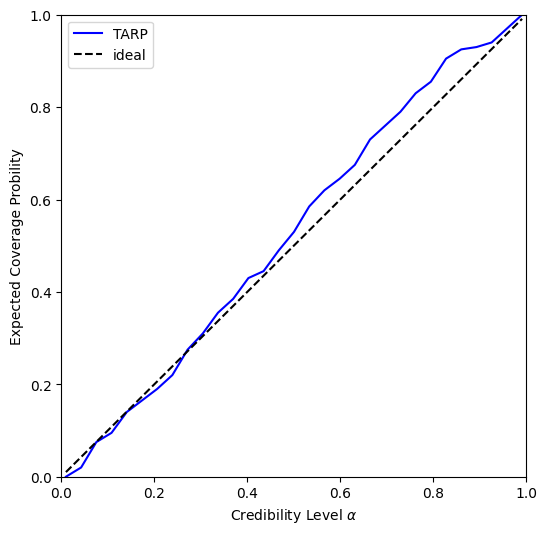

In [29]:
# Or, we can perform a visual check.
from sbi.analysis.plot import plot_tarp
plot_tarp(ecp, alpha);

In contrast to SBC (Talts et al.) and coverage based highest posterior density regions
(Deistler et al.,), TARP provides a necessary *and sufficient* condition for posterior
accuracy, i.e., it can also detect inaccurate posterior estimators. 

Note, however, that this property depends on the choice of reference point distribution:
to obtain the full diagnostic power of TARP, one would need to sample reference points
from a distribution that depends on $x$. Thus, in general, we recommend using and
interpreting TARP like SBC and complementing coverage checks with posterior predictive
checks.